In [ ]:
# For importing the data and normalizing it
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


(x_train1, y_train), (x_test1, y_test) = tf.keras.datasets.cifar10.load_data()

x_train_unnormal = x_train1
x_test_unnormal = x_test1

x_train_unnormal = x_train_unnormal.reshape(50000,3072)
x_test_unnormal = x_test_unnormal.reshape(10000,3072)

x_train = x_train1/255.0
x_test = x_test1/255.0

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
import numpy as np

def relu(x):
    return np.maximum(0, x)  

def relu_derivative(x):
    return (x > 0).astype(int) # return 1 if positive (true) and 0 otherwise (false)

def leaky_relu(x, slope = 0.01):
    return np.maximum(slope*x, x)

def leaky_relu_derivative(x, slope = 0.01):
    dx = np.ones_like(x) #initialize all derivatives to 1
    dx[x < 0] = slope #if x < 0, change derivative to slope 
    return dx

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

In [ ]:
class MLP2:      
    def __init__(self, activation, activation_derivative, hidden_layers, hidden_units):
        # Initialize the MLP with the given activation function and its derivative, number of hidden layers, and number of hidden units per layer
        self.activation = activation
        self.activation_derivative = activation_derivative
        self.hidden_layers = hidden_layers
        self.hidden_units = hidden_units
        self.weights = []
        self.biases = []
        self.h = [None]*(hidden_layers+2) #activation of all hidden layers, input, and output
        
        if hidden_layers == 0:
              self.weights.append(np.random.randn(3072,10)*0.01) #number of classes is rows, number of hidden units in last hidden layer is columns
              self.biases.append(np.random.randn(10, 1)*0.01)             
          
        else:
            # Initialize the weights and biases for each layer
            for i in range(hidden_layers):
                # Input layer
                if i == 0:
                    self.weights.append(np.random.randn(3072,hidden_units[0])*0.01) #number of hidden units in next layer is number of rows, number of inputs per instance in number of columns
                    self.biases.append(np.random.randn(hidden_units[0], 1)*0.01) 
                # Hidden layers
                else:
                    self.weights.append(np.random.randn(hidden_units[i-1], hidden_units[i])*0.01) #number of hidden units in next layer is number of rows, number of units in current layer is number of columns
                    self.biases.append(np.random.randn(hidden_units[i], 1)*0.01) 
                    
            # Output layer
            self.weights.append(np.random.randn(hidden_units[-1],10)*0.01) #number of classes is rows, number of hidden units in last hidden layer is columns
            self.biases.append(np.random.randn(10, 1)*0.01)

    def plot_accuracy(self, train_accuracies, test_accuracies):
        epochs = range(1, len(train_accuracies) + 1)
        plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
        plt.plot(epochs, test_accuracies, 'r', label='Test accuracy') 
        plt.legend()        
        plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
        plt.plot(epochs, test_accuracies, 'ro', label='Test accuracy')
        plt.title('Accuracy progression as a function of epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.show()   

    def softmax(self,x):
        #subtract the maximum value in each row to avoid overflow when exponentiating large values
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        s = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return s
    
    def transform_y(self,y_batch): #transform true labels vector to NXC matrix for backpropagation
        transformed_y = np.zeros((y_batch.shape[0],10))
        for i in range(y_batch.shape[0]):
            transformed_y[i][y_batch[i]] = 1
        return transformed_y 
      
    def forward(self, x): 
        h = [x] #sotres input for each layer
        for i in range(len(self.weights)):
            if i == len(self.weights) - 1: #activate output layer with softmax
                h_l = self.softmax(np.dot(h[-1], self.weights[i]) + self.biases[i].T) #h[-1] is previous output, so current layer's input
            else:
                h_l = self.activation(np.dot(h[-1], self.weights[i]) + self.biases[i].T) #h[-1] is previous output, so current layer's input
            h.append(h_l)
        return h
    
    def backpropagation(self, X, y, h, y_hat, learning_rate, l1, l2): 
        m = X.shape[0] #batch size 
        y = self.transform_y(y) #NxC
        dZ = y_hat - y #NxC
        dW = np.dot(h[-2].T,dZ) / m + l1*np.sign(self.weights[-1]) + l2*self.weights[-1] # MxN X NxC, derivative of weights, l1 and l2 regularization
        dB = np.sum(dZ, axis=0, keepdims=True) / m #1xC, derivative of biases
        
        #dZ for subsequent layer
        dA = np.dot(dZ, self.weights[-1].T) #NxC X CxM
        dH = dA * self.activation_derivative(h[-2])
        
        #store in list for GD
        dW_list = [dW] 
        dB_list = [dB]

        for i in range(len(self.weights) - 2, -1, -1): #go over remaining layers, same idea as above
            dW = np.dot(h[i].T,dH) / m + l1*np.sign(self.weights[i]) + l2*self.weights[i] #l1 and l2 regularization
            dB = np.sum(dH, axis=0, keepdims=True) / m
            dA = np.dot(dH, self.weights[i].T)
            dH = dA * self.activation_derivative(h[i])

            dW_list.append(dW)
            dB_list.append(dB)
        
        #reverse lists to store derivatives from 1st to last layer
        dW_list.reverse()
        dB_list.reverse()
        
        #GD

        return dB_list, dW_list
  
   
    def to_categorical(self,y):  
        # transform probabilities into categorical predictions by taking the max probability
        categorical = np.zeros((y.shape[0],y.shape[1]))
        categorical[np.arange(y.shape[0]),y.argmax(axis=1)] = 1
        return categorical
    
    def fit(self, x_train, y_train, x_test, y_test, epochs, learning_rate, batch_size, l1=0, l2=0, alpha=0): 

        test_accuracy = []
        train_accuracy = []
  
        for epoch in range(epochs):
            dW_prev = [np.zeros(w.shape) for w in self.weights]
            dB_prev = [np.zeros(b.shape) for b in self.biases] 
            
            #shuffle data
            indices = np.random.permutation(x_train.shape[0])
            x_shuffled = x_train[indices]
            y_shuffled = y_train[indices]
            
            #SGD on batches, performing a forward and backward pass in each iteration
            for i in range(0, x_train.shape[0], batch_size):
                x_batch = x_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                h = self.forward(x_batch)
                y_hat = h[-1]
                dB, dW = self.backpropagation(x_batch, y_batch, h, y_hat, learning_rate, l1, l2)

                
                if alpha!=0:
                    for k in range(len(dW)):
                        # print('k =', k)
                        # print('dB_prev[k].T:', dB_prev[k].T.shape)
                        # print('dB[k]', dB[k].shape)
                        dW[k] = alpha*dW_prev[k] + (1-alpha)*dW[k]
                        dB_p = dB_prev[k] if i!=0 else dB_prev[k].T
                        dB[k] = alpha*(dB_p) + (1-alpha)*dB[k]

                    # dW = [alpha*prev + (1-alpha)*current for prev,current in zip(dW_prev,dW)]
                    # dB = [alpha*np.array(prev) + (1-alpha)*np.array(current) for prev,current in zip(dB_prev,dB)] if i==0 \
                    #      else [alpha*prev + (1-alpha)*current for prev,current in zip(dB_prev,dB)]


                for j in range(len(self.weights)):
                    self.weights[j] -= learning_rate * dW[j]
                    self.biases[j] -= learning_rate * dB[j].T
                    dB_prev[j] = dB[j]
                    dW_prev[j] = dW[j]

            pred_train = self.predict(x_train)
            pred_test = self.predict(x_test)
            acc_train = self.evaluate_acc(pred_train,y_train)
            acc_test = self.evaluate_acc(pred_test, y_test)
            
            train_accuracy.append(acc_train)
            test_accuracy.append(acc_test)
            
            print('Epoch:', epoch+1, ', train accuracy:', acc_train, 'and test accuracy:', acc_test) 

        self.plot_accuracy(train_accuracy, test_accuracy)
                            
    def predict(self,x):
        y_hat = self.forward(x)[-1]
        return self.to_categorical(y_hat) #return categorical predictions
    
    def evaluate_acc(self, y_pred, y): 
        y = self.transform_y(y) #transform true labels to matrix
        correct = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1)) #number of correct predictions
        total = y.shape[0] #total number of predictions 
        accuracy = correct/total #accuracy
        return accuracy

Epoch: 1 , train accuracy: 0.16686 and test accuracy: 0.1611


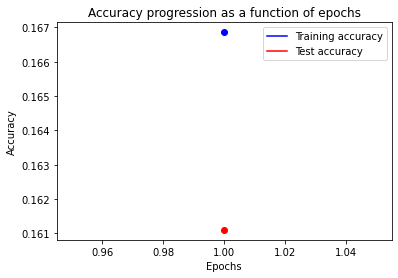

Epoch: 1 , train accuracy: 0.2357 and test accuracy: 0.2367


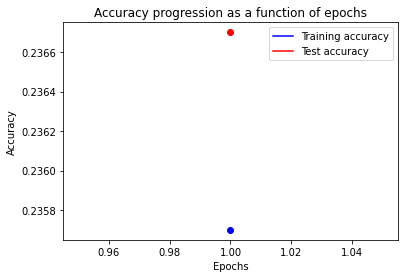

Epoch: 1 , train accuracy: 0.35232 and test accuracy: 0.3486


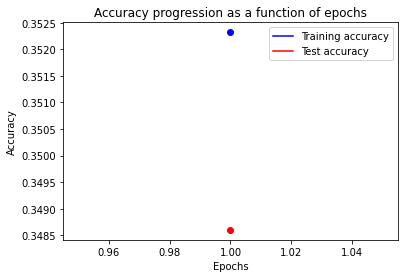

In [ ]:
#0, 1, 2 hidden layers
m = MLP2(relu,relu_derivative,2,[256,256])
m.fit(x_train, y_train, x_test, y_test, 200, 0.001, 16)
    
m = MLP2(relu,relu_derivative,1,[256])
m.fit(x_train, y_train, x_test, y_test, 150, 0.001, 16)
    
m = MLP2(relu,relu_derivative,0,[])
m.fit(x_train, y_train, x_test, y_test, 150, 0.001, 16)

In [ ]:
#leaky relu and tanh
m = MLP2(tanh,tanh_derivative,2,[256,256])
m.fit(x_train, y_train, x_test, y_test, 100, 0.001, 16)

m = MLP2(leaky_relu,leaky_relu_derivative,2,[256,256])
m.fit(x_train, y_train, x_test, y_test, 150, 0.001, 16)

Epoch: 1 , train accuracy: 0.39988 and test accuracy: 0.3957


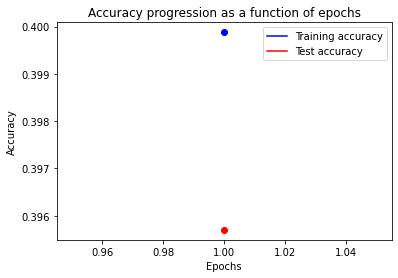

In [ ]:
#unnormalized training
m = MLP2(relu,relu_derivative,2,[256,256])
m.fit(x_train_unnormal, y_train, x_test_unnormal, y_test, 100, 0.001, 16)

Epoch: 1 , train accuracy: 0.09998 and test accuracy: 0.1001


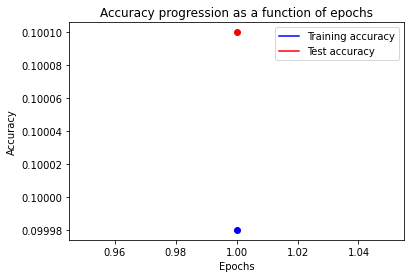

Epoch: 1 , train accuracy: 0.10908 and test accuracy: 0.1079


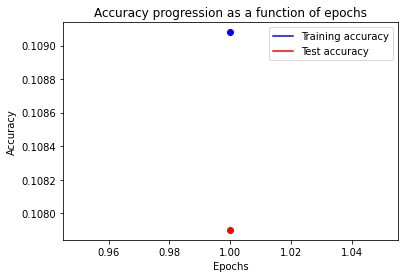

In [ ]:
#regularization
m = MLP2(relu,relu_derivative,2,[256,256])
m.fit(x_train, y_train, x_test, y_test, 100, 0.001, 16, l1=0, l2=0.01)#L2 regularization

m = MLP2(relu,relu_derivative,2,[256,256])
m.fit(x_train, y_train, x_test, y_test, 100, 0.001, 16, l1=0.0001, l2=0)#L1 regularization

In [ ]:
#hyperparameter tuning
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],  # l1 and l2 regularization
    'learning_rate_init': [0.0001, 0.001, 0.01],  # learning rate
    'batch_size': [16, 32, 64]  # batch size
}

mlp = MLPClassifier(hidden_layer_sizes=(256, 256), activation='relu', max_iter=200, random_state=42)
grid_search = GridSearchCV(mlp, param_grid, cv=5)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_

print('Best hyperparameters:', grid_search.best_params_)

Epoch: 1 , train accuracy: 0.25996 and test accuracy: 0.254


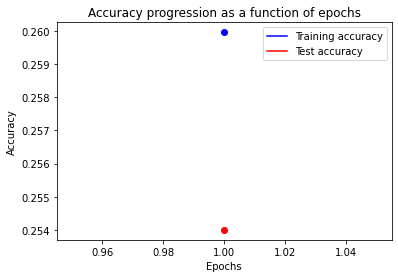

In [ ]:
#momentum
m = MLP2(relu,relu_derivative,2,[256,256])
m.fit(x_train, y_train, x_test, y_test, 50, 0.01, 16, alpha=0.9)

tensor flow CNN loading the data
-yanying


170498071/170498071 [==============================] - 8s 0us/step


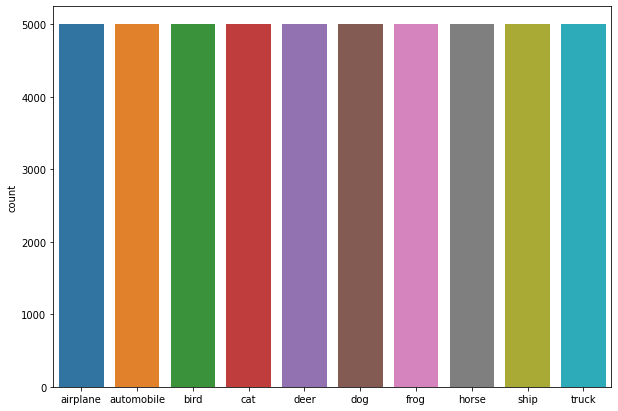

In [ ]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore') 

#TensorFlow - Importing the Libraries
import tensorflow as tf
from tensorflow import keras

#PyTorch - Importing the Libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms
import seaborn as sns

#oepn the dataset tensor flow way
(x_train1, y_train), (x_test1, y_test) = tf.keras.datasets.cifar10.load_data()

y_train = y_train.flatten()
y_test = y_test.flatten()
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,7))
p = sns.countplot(y_train.flatten())
p.set(xticklabels=classes)
#check nan value
np.isnan(x_train1).any()
np.isnan(x_test1).any()

input_shape = (32, 32, 3)

x_train=x_train1.reshape(x_train1.shape[0], x_train1.shape[1], x_train1.shape[2], 3)
x_train=x_train / 255.0
x_test = x_test1.reshape(x_test1.shape[0], x_test1.shape[1], x_test1.shape[2], 3)
x_test=x_test / 255.0

y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)



tensor flow CNN algorithm -yanying

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(10,), dtype=float32)
Epoch 1/50
1563/1563 [==============================] - 18s 6ms/step - loss: 1.8276 - acc: 0.3282
Epoch 2/50
1563/1563 [==============================] - 10s 7ms/step - loss: 1.5098 - acc: 0.4527
Epoch 3/50
1563/1563 [==============================] - 12s 8ms/step - loss: 1.3759 - acc: 0.5051
Epoch 4/50
1563/1563 [==============================] - 10s 7ms/step - loss: 1.2795 - acc: 0.5475
Epoch 5/50
1563/1563 [==============================] - 10s 7ms/step - loss: 1.2050 - acc: 0.5736
Epoch 6/50
1563/1563 [==============================] - 10s 7ms/step - loss: 1.1345 - acc: 0.6018
Epoch 7/50
1563/1563 [==============================] - 10s 7ms/step - loss: 1.0806 - acc: 0.6208
Epoch 8/50
1563/1563 [==============================] - 17s 11ms/step - loss: 1.0342 - acc: 0.6397
Epoch 9/50
1563/1563 [==============================] - 21s 13ms/step - loss: 0.9947 - acc: 0.6503
Epoch 10/50
1563/1563 [======================

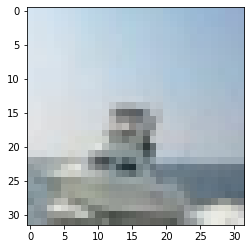

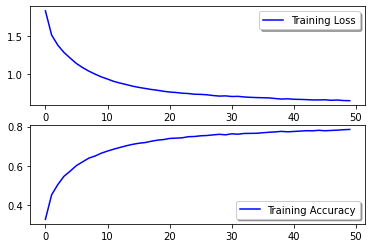

In [ ]:
plt.imshow(x_train[100])
print(y_train[100])

batch_size = 32
num_classes = 10
epochs = 50

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=x_train.shape[1:], activation='relu'),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])

model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001, decay=1e-06),
            loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, batch_size=batch_size,
                    epochs=epochs)
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
legend = ax[1].legend(loc='best', shadow=True)


predict result

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
train_loss, train_acc=model.evaluate(x_train, y_train)

1563/1563 [==============================] - 6s 4ms/step - loss: 0.5080 - acc: 0.8358


['loss', 'acc']
[0.684784471988678, 0.7750999927520752]


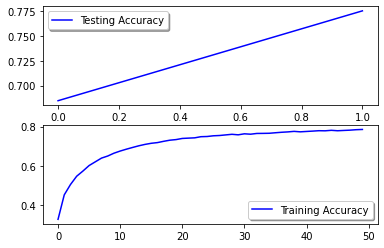

In [ ]:
score = model.evaluate(x_test, y_test, batch_size=128, verbose=0)
print(model.metrics_names)
print(score)
fig, ax = plt.subplots(2,1)
ax[0].plot(score, color='b', label="Testing Accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
legend = ax[1].legend(loc='best', shadow=True)


313/313 [==============================] - 2s 5ms/step


[[Text(0.5, 0, 'airplane'),
  Text(1.5, 0, 'automobile'),
  Text(2.5, 0, 'bird'),
  Text(3.5, 0, 'cat'),
  Text(4.5, 0, 'deer'),
  Text(5.5, 0, 'dog'),
  Text(6.5, 0, 'frog'),
  Text(7.5, 0, 'horse'),
  Text(8.5, 0, 'ship'),
  Text(9.5, 0, 'truck')],
 [Text(0, 0.5, 'airplane'),
  Text(0, 1.5, 'automobile'),
  Text(0, 2.5, 'bird'),
  Text(0, 3.5, 'cat'),
  Text(0, 4.5, 'deer'),
  Text(0, 5.5, 'dog'),
  Text(0, 6.5, 'frog'),
  Text(0, 7.5, 'horse'),
  Text(0, 8.5, 'ship'),
  Text(0, 9.5, 'truck')]]

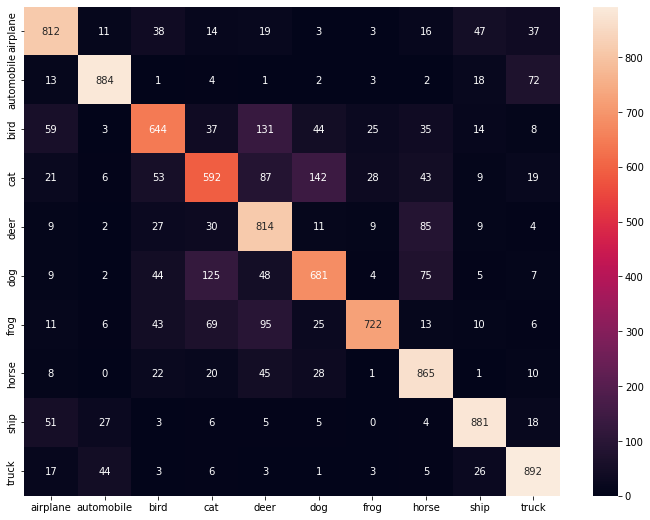

In [ ]:
# Predict the values from the validation dataset
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 9))
c = sns.heatmap(confusion_mtx, annot=True, fmt='g')
c.set(xticklabels=classes, yticklabels=classes)


In [ ]:
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt

base_model = ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape = (32, 32, 3))

for layer in base_model.layers:
  layer.trainable = False

x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
y_hat = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=y_hat)

model.compile(
    optimizer = 'SGD',
    loss = "sparse_categorical_crossentropy",
    metrics = ['accuracy'])

results = model.fit(x_train_unnormal, 
          y_train,
          verbose = 1, 
          validation_data=(x_test_unnormal, y_test), 
          epochs=20)

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model Accuracy as a Function of Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Data', 'Test Data'])
plt.show()